# **COMP 5313**
# **Assignment 1 - MLP from scratch in python**
# **Name: Archana Devi Ramesh**
# **ID: 1158923**

## Classification 

Dataset 
**https://archive.ics.uci.edu/ml/datasets/iris** 

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
np.random.seed(42)

In [2]:
#to read dataset
def readdata():
    read_file = pd.read_csv(r'iris.txt')
    read_file.to_csv (r'iris.csv', index=None)
    #Reading the dataset
    df = pd.read_csv('iris.csv')
    return df

#basic data analysis
def data_analysis(df):
    print("Class distribution of classes:\n", df['class'].value_counts())
    count_class = pd.value_counts(df['class'], sort=True)
    count_class.plot(kind = 'bar',rot = 0)
    plt.title("Class distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

#preparing X and Y values train and test data
def prepare_data(df):
    #Taking X and y values 
    X = df.iloc[:, :-1].values
    Y = df.iloc[:, -1].values

    #normalizing the values
    std_scaler = StandardScaler()
    X = std_scaler.fit_transform(X)
    
    #one-hot encoding of class values
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y)
    Y = Y.reshape(-1,1)
    one_encoder = preprocessing.OneHotEncoder()
    Y = one_encoder.fit_transform(Y).toarray()
    
    #splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify = Y)
    return X_train, X_test, y_train, y_test

#calculating accuracy
def calc_accuracy(actual, pred):
    count = 0
    length = len(actual)
    for i in range(length):
        if actual[i] == pred[i]:
            count += 1
    accu = (count/float(length)) * 100.0
    return accu


#basic train method
def train(model_class, epochs, X_train, y_train):
    loss = []
    for epoch in range(epochs): 
        if epoch < 100:
            learn_rate = 0.5
        elif epoch >= 100 and epoch < 300:
            learn_rate = 0.05
        else:
            learn_rate = 0.01  
        pred_l, pred = model_class.train_MLP(X_train, y_train, learn_rate)
        loss_val = model_class.cross_entropy_loss(pred_l, y_train)
        loss.append(loss_val)
       
    pred_new = np.argmax(pred,axis=1)
    y_new = np.argmax(y_train,axis=1)
    train_accuracy = calc_accuracy(y_new, pred_new)
    return train_accuracy, loss


#prediction method
def test(model_class, X_test, y_test):
    test_pred = model_class.forward_propagate(X_test)
    b = np.zeros_like(test_pred)
    b[np.arange(len(test_pred)), test_pred.argmax(1)] = 1
    test_pred = np.argmax(b,axis=1)
    y_test = np.argmax(y_test,axis=1)
    test_accuracy = calc_accuracy(y_test, test_pred)
    return test_accuracy

#graph to plot curve
def plot_loss(val):
    xval = list(range(0, len(val)))
    yval = val
    plt.title("Cross entropy loss curve")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.plot(xval, yval)  
    plt.show()

In [3]:
#Creating neural network class given in the question
class MLP():
    def __init__(self, in_neuron, out_neuron, hidden_neuron):
        self.inputs = in_neuron #input neurons
        self.outputs = out_neuron #output neurons
        self.hidden_neurons = hidden_neuron #hidden neurons
        
        #initializing weights and bias for layer1
        self.W1 = np.random.randn(self.inputs, self.hidden_neurons) 
        self.b1 = np.zeros((1, self.hidden_neurons))
        
        #initializing weights and bias for layer2
        self.W2 = np.random.randn(self.hidden_neurons, self.outputs)
        self.b2 = np.zeros((1, self.outputs))
        
    #getting parameters
    def get_params(self):
        print("Layer1 Weight:\n", self.W1)
        print("Layer1 Bias:\n", self.b1)
        print("Layer2 Weight:\n", self.W2)
        print("Layer2 Bias:\n", self.b2)      
        
    #to calculate sigmoid
    def sigmoid(self, s):
        s = 1/(1 + np.exp(-s))
        return s
    
    #to calculate derivative of sigmoid
    def der_sigmoid(self, s):
        s = s * (1 - s)
        return s
    
    #to calculate softmax
    def softmax(self, s):
        return np.exp(s) / np.sum(np.exp(s), axis=1, keepdims=True)
    
    #forward propagation in two layers
    def forward_propagate(self, X):  
        self.Z1 = self.sigmoid(np.dot(X, self.W1) + self.b1) 
        output = self.softmax(np.dot(self.Z1, self.W2) + self.b2)  
        return output   
    
    #backward propogation in two layers
    def backward_propagate(self, X, y, out, LR):
        #calculating gradients
        #layer1
        output_err = out - y
        self.cost_W2 = np.dot(self.Z1.T, output_err)
        self.cost_b2 = output_err
        
        #layer2
        part1 = np.dot(output_err, self.W2.T)
        part2 = np.multiply(part1, self.der_sigmoid(self.Z1))
        self.cost_W1 = np.dot(X.T, part2)
        self.cost_b1 = part2  
        
        #updating weights and bias of layer2
        self.W2 = self.W2 - np.multiply(LR, self.cost_W2)
        self.b2 = self.b2 - np.multiply(LR, self.cost_b2.sum(axis=0))
        
        #updating weights and bias of layer1
        self.W1 = self.W1 - np.multiply(LR, self.cost_W1)
        self.b1 = self.b1 - np.multiply(LR, self.cost_b1.sum(axis=0))
        
    #calculating cross entropy loss
    def cross_entropy_loss(self, pred, y):
        return np.sum(-(y * np.log(pred)))
        
    
    #calculating predictions using forward propagation and updating weights using backward propagation
    def train_MLP(self, X, y, LR):
        output_nn = self.forward_propagate(X)
        b = np.zeros_like(output_nn)
        b[np.arange(len(output_nn)), output_nn.argmax(1)] = 1
        self.backward_propagate(X, y, b, LR)
        return output_nn, b

Reading IRIS Dataset ... 
IRIS Dataset:
      sepal_length  sepal_width  petal_length  petal_width           class
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

Data analysis ... 
Class distribution of class

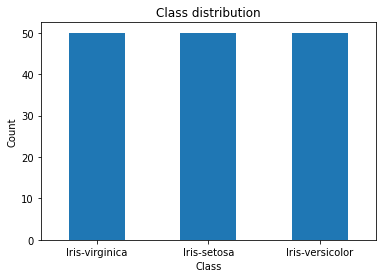


Preparing X and Y train and test data ... 

X Train size: (120, 4), X Test size: (30, 4) 
Y Train size: (120, 3), Y Test size: (30, 3) 

Training the MULTILAYER PERCEPTRON NETWORK .....

Weights and bias initialization before training
Layer1 Weight:
 [[-1.1913035   0.65655361 -0.97468167  0.7870846   1.15859558 -0.82068232]
 [ 0.96337613  0.41278093  0.82206016  1.89679298 -0.24538812 -0.75373616]
 [-0.88951443 -0.81581028 -0.07710171  0.34115197  0.2766908   0.82718325]
 [ 0.01300189  1.45353408 -0.26465683  2.72016917  0.62566735 -0.85715756]]
Layer1 Bias:
 [[0. 0. 0. 0. 0. 0.]]
Layer2 Weight:
 [[-1.0708925   0.48247242 -0.22346279]
 [ 0.71400049  0.47323762 -0.07282891]
 [-0.84679372 -1.51484722 -0.44651495]
 [ 0.85639879  0.21409374 -1.24573878]
 [ 0.17318093  0.38531738 -0.88385744]
 [ 0.15372511  0.05820872 -1.1429703 ]]
Layer2 Bias:
 [[0. 0. 0.]]

Weights and bias after training
Layer1 Weight:
 [[   0.34035942   -2.46169021   -1.63004011   -1.77198507  167.91377631
    -2.77174

<ipython-input-3-c7eaebe17475>:25: RuntimeWarning: overflow encountered in exp
  s = 1/(1 + np.exp(-s))


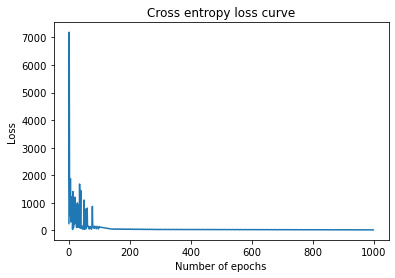

In [4]:
#starting point of execution 
if __name__ == '__main__':
    
    start = time.time()
    print("Reading IRIS Dataset ... ")
    df = readdata()
    print("IRIS Dataset:\n", df)
    print("\nData analysis ... ")
    data_analysis(df)
    print("\nPreparing X and Y train and test data ... ")
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    print('\nX Train size: {train}, X Test size: {test} '.format(train=X_train.shape, test=X_test.shape))
    print('Y Train size: {train}, Y Test size: {test} '.format(train=y_train.shape, test=y_test.shape))
    
    model_class = MLP(X_train.shape[1], y_train.shape[1], 6)
    epochs = 1000
    print("\nTraining the MULTILAYER PERCEPTRON NETWORK .....")
    print("\nWeights and bias initialization before training")
    model_class.get_params()
    train_accuracy, loss = train(model_class, epochs, X_train, y_train)
    print("\nWeights and bias after training")
    model_class.get_params()
    print("\nTraining accuracy after {} epochs: {} ".format(epochs, train_accuracy))
    end = time.time()
    print("\nTraining Completed. Total time taken: {}seconds".format(int(end-start)))
    print("\n\nTesting the MULTILAYER PERCEPTRON NETWORK .....")
    test_accuracy = test(model_class, X_test, y_test) 
    print("Testing Accuracy: ", test_accuracy)
    print("\n\nPrinting Cross Entropy Loss curve")
    plot_loss(loss)
    
    
